In [109]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
from torch import nn
from sklearn.metrics import accuracy_score

In [71]:
from cassava.transforms import get_test_transforms

In [72]:
%matplotlib inline

In [73]:
metrics = context.catalog.load('train_metrics')

2020-12-04 16:47:32,656 - kedro.io.data_catalog - INFO - Loading data from `train_metrics` (PickleDataSet)...


In [74]:
metrics['last_epoch']

19

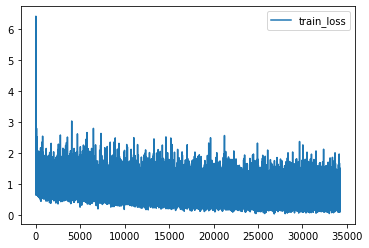

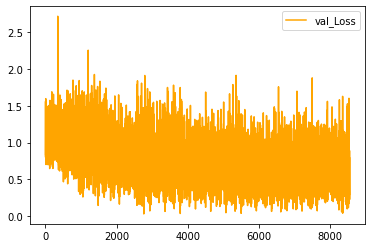

In [75]:
plt.figure()
sns.lineplot(data=metrics['train_losses'], label='train_loss')
plt.show()

plt.figure()
sns.lineplot(data=metrics['validation_losses'], label='val_Loss', color='orange')
plt.show()

In [76]:
val_scores = context.catalog.load('val_scores')
val_scores

2020-12-04 16:47:36,397 - kedro.io.data_catalog - INFO - Loading data from `val_scores` (PickleDataSet)...


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'accuracy': 0.775233644859813,
 'confusion_matrix': array([[  37,   17,    2,    1,   21],
        [  16,  172,    4,   14,    4],
        [   5,   62,  219,   55,   22],
        [  17,   96,  130, 2492,   71],
        [ 142,   91,  122,   70,  398]]),
 'f1_score': 0.7900267530037505}

In [8]:
#!curl https://raw.githubusercontent.com/DTrimarchi10/confusion_matrix/master/cf_matrix.py -O cf_matrix.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4088  100  4088    0     0   9290      0 --:--:-- --:--:-- --:--:--  9290
curl: (6) Could not resolve host: cf_matrix.py


In [77]:
from cf_matrix import make_confusion_matrix

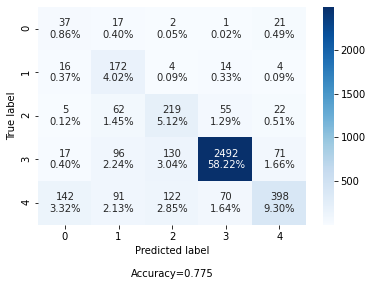

In [78]:
make_confusion_matrix(val_scores['confusion_matrix'])

In [79]:
model = context.catalog.load('model')

2020-12-04 16:47:59,768 - kedro.io.data_catalog - INFO - Loading data from `model` (TorchLocalModel)...


Using cache found in /home/boris/.cache/torch/hub/pytorch_vision_v0.6.0


In [80]:
model.eval()

ResnetModel(
  (trunk): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [81]:
def plot_image(img, label=None, ax=None):
    if not ax:
        ax = plt.gca()
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')
    if label is not None:
        
        if isinstance(label, int):
            label = label_num_to_disease_map.get(label, 0)
        ax.set_title(f'L: {label}')

In [82]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-04 16:48:02,768 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [83]:
train_images_torch.transform = get_test_transforms()

In [84]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unnorm = UnNormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Predict on random image

In [90]:
nn.functional.softmax(torch.Tensor([[5, 100], [5, 100]]), dim=0)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000]])

In [91]:
train_images_torch.transform = get_test_transforms()

In [100]:
def predict(model, x, invtemp=1):
    logits = model.forward(x)
    probabilities = nn.functional.softmax(invtemp*logits, dim=1)
    return probabilities

def pred_label(model, x, invtemp=1):
    return torch.max(predict(model, x, invtemp=invtemp), 1)[1]

def predict_diff_temps(model, x, invtemps):
    logits = model.forward(x)
    
    return {
        temp: nn.functional.softmax(temp*logits, dim=1) for temp in invtemps
    }


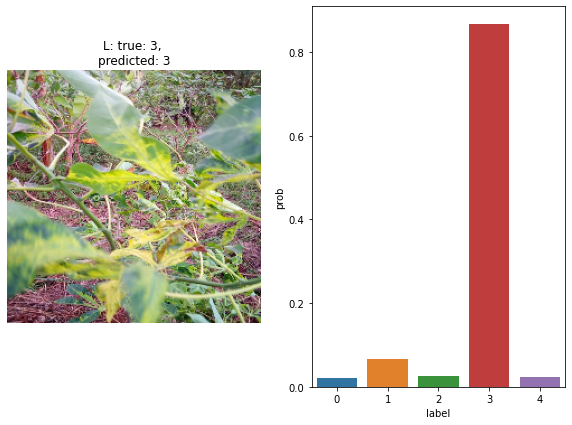

In [93]:
random_idx = np.random.choice(range(len(train_images_torch)))
image, label = train_images_torch[random_idx]

probabilities = predict(model, image.unsqueeze(0), invtemp=0.5)[0]
prediction = pred_label(model, image.unsqueeze(0)).item()

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plot_image(unnorm(image), label=f"true: {label}, \npredicted: {prediction}")
plt.subplot(1, 2, 2)
sns.barplot(y=probabilities.detach().numpy(), x=list(range(5)))
plt.xlabel('label')
plt.ylabel('prob')
plt.show()

# Calibration curves

In [94]:
from sklearn.calibration import calibration_curve

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
from cassava.extras.datasets.image_dataset import DatasetFromSubset
import torch

In [96]:
indices = np.random.choice(range(len(train_images_torch)), 2000)

In [97]:
train_images_torch.transform = None

In [98]:
dataset = DatasetFromSubset(torch.utils.data.Subset(train_images_torch, indices=indices),
                      transform=get_test_transforms())
loader = torch.utils.data.DataLoader(dataset, batch_size=10)

In [106]:
predictions = {}
true_labels = []

invtemps = [0.5, 1, 5, 10, 100]

for temp in invtemps:
    predictions[temp] = []

model.eval()
for images, labels in tqdm(loader):
    preds =  predict_diff_temps(model, images, invtemps)
    for temp in invtemps:
        predictions[temp] += preds[temp].tolist()
    true_labels += labels.tolist()

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 200/200 [01:17<00:00,  2.58it/s]


In [125]:
for temp in invtemps:
    predictions[temp] = np.array(predictions[temp])
true_labels = np.array(true_labels)

In [126]:
true_labels[:10]

array([3, 3, 3, 2, 3, 3, 3, 4, 3, 3])

In [131]:
predictions[1][:10]

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[9.10331873e-05, 1.09567330e-03, 1.98294307e-04, 9.98441517e-01,
        1.73534470e-04],
       [1.06200887e-05, 6.12639298e-04, 8.83648455e-01, 1.15438625e-01,
        2.89710617e-04],
       [8.09070244e-02, 5.10363430e-02, 2.60601550e-01, 2.22459927e-01,
        3.84995162e-01],
       [3.17079462e-02, 2.73220539e-02, 4.46483016e-01, 1.56224132e-01,
        3.38262826e-01],
       [3.59913131e-04, 1.52553793e-03, 2.04691221e-03, 9.94470358e-01,
        1.59738911e-03],
       [1.28599873e-04, 1.34977372e-03, 3.21627595e-03, 9.94829595e-01,
        4.75787587e-04],
       [7.81521760e-03, 8.47643614e-03, 1.42643461e-02, 9.46635842e-01,
        2.28080712e-02],
       [2.30964661e-01, 4.66312617e-02, 4.01707329e-02, 6.34685950e-03,
        6.75886512e-01],
       [2.01932970e-04, 4.64650278e-04, 1.50983501e-03, 9.96208072e-01,
        1.61540904e-03],
       [7.18112506e-06, 3.91633475e-05, 5.73788118e-03, 9.94046569e-01,
        1.69257561e-04]])

[0.776, 0.776, 0.776, 0.776, 0.776]


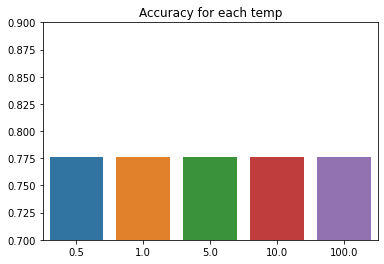

In [128]:
accuracies = []
for temp in invtemps:
    pred_probs = predictions[temp]
    pred_labels = np.argmax(pred_probs, 1)
    
    accuracies.append(accuracy_score(true_labels, pred_labels))
print(accuracies)
plt.figure()
sns.barplot(x=invtemps, y=accuracies)
plt.title('Accuracy for each temp')
plt.ylim(0.7, 0.9)
plt.show()

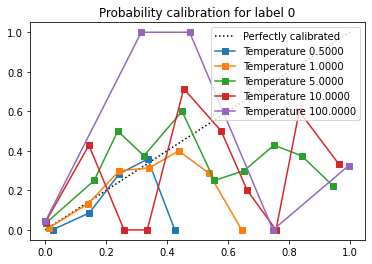

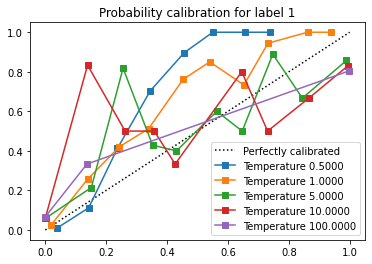

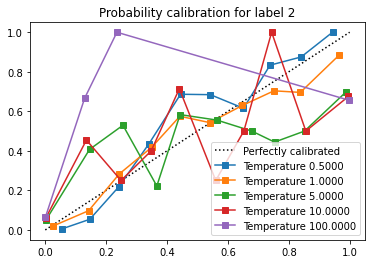

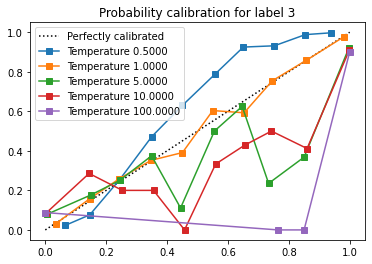

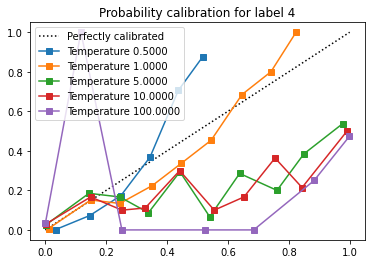

In [130]:
for label in [0, 1, 2, 3, 4]:
    plt.figure()
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.title(f'Probability calibration for label {label}')
    true_label = (true_labels == label)
    
    for temp in invtemps:
        pred_prob = predictions[temp][:, label]
    
        fraction_of_positives, mean_predicted_value = \
                calibration_curve(true_label, pred_prob, n_bins=10)

        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"Temperature {temp:0.4f}")
    plt.legend()
    plt.show()